# Ensemble : Bagging

## 1.환경준비

### (1) import

In [2]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 모델링
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import * 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings    # 경고메시지 제외
warnings.filterwarnings(action='ignore')

### (2) 데이터 준비

* 변수설명
    * COLLEGE : 대학 졸업여부
    * INCOME : 연수입
    * OVERAGE : 월평균 초과사용 시간(분)
    * LEFTOVER : 월평균 잔여시간비율(%)
    * HOUSE : 집값
    * HANDSET_PRICE : 스마트폰 가격
    * OVER_15MINS_CALLS_PER_MONTH : 월평균 장기통화(15분이상) 횟수
    * AVERAGE_CALL_DURATION : 평균 통화 시간
    * REPORTED_SATISFACTION : 만족도 설문조사 결과
    * REPORTED_USAGE_LEVEL : 사용도 자가진단 결과
    * CONSIDERING_CHANGE_OF_PLAN : 향후 변경계획 설문조사 결과
    * CHURN : 이탈(번호이동) 여부 (1-이탈, 0-잔류, Target 변수)


In [3]:
# 데이터를 불러옵시다.
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_cust_churn.csv'
data = pd.read_csv(path)
data = data.sample(5000, random_state = 2022)
data['CHURN'] = data['CHURN'].map({'LEAVE':1, 'STAY':0})
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
3178,3179,0,119512,51,31,248566,229,5,2,very_sat,very_high,considering,1
14926,14927,1,142144,192,15,774317,581,29,4,unsat,very_little,never_thought,1
15116,15117,1,142308,0,79,306426,497,1,1,sat,little,considering,0
12733,12734,1,113385,0,0,333599,819,1,6,very_unsat,very_high,considering,1
14032,14033,1,90348,209,10,637286,360,26,4,unsat,little,actively_looking_into_it,0


## 2.데이터 준비

### (1) 데이터 정리

In [4]:
drop_cols = ['id']
data.drop(drop_cols, axis = 1, inplace = True )

### (2) 데이터분할1 : x, y 나누기

In [5]:
target = 'CHURN'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (3) NA 조치

### (4) 가변수화

In [6]:
dumm_cols = ['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
x = pd.get_dummies(x, columns = dumm_cols, drop_first = True)

### (5) 데이터분할2 : train : validation

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3, random_state = 2022)

## 3.모델링 : 랜덤포레스트


In [8]:
# 모델 선언 # 현장에서 많이씀(성능이 좋기때문)
model = RandomForestClassifier(n_estimators = 5, max_depth = 3) # 트리 다섯개를 3번씩 탐색 -->default는 100개

In [9]:
# 학습
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=5)

In [10]:
# 예측
pred = model.predict(x_val)

In [11]:
# 평가
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.73      0.63      0.68       769
           1       0.66      0.75      0.70       731

    accuracy                           0.69      1500
   macro avg       0.69      0.69      0.69      1500
weighted avg       0.70      0.69      0.69      1500



## 4.시각화와 변수중요도

### (1) 모델의 내부를 살펴봅시다.

In [12]:
# 5개 decision tree
model.estimators_[4].predict(x_val)

array([1., 0., 1., ..., 1., 0., 1.])

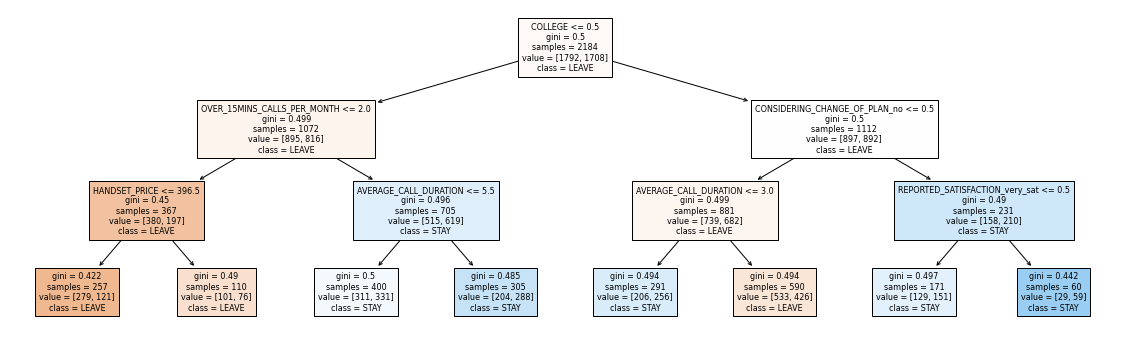

In [13]:
# 각 트리별로 시각화 할 수 있다.
plt.figure(figsize=(20,6))
plot_tree(model.estimators_[0], 
               feature_names = x_train.columns,
               class_names= ['LEAVE','STAY'], 
               filled = True, fontsize = 8);

### (2) 변수 중요도

In [14]:
# 변수 중요도
print(x_train.columns)
print(model.feature_importances_)

Index(['COLLEGE', 'INCOME', 'OVERAGE', 'LEFTOVER', 'HOUSE', 'HANDSET_PRICE',
       'OVER_15MINS_CALLS_PER_MONTH', 'AVERAGE_CALL_DURATION',
       'REPORTED_SATISFACTION_sat', 'REPORTED_SATISFACTION_unsat',
       'REPORTED_SATISFACTION_very_sat', 'REPORTED_SATISFACTION_very_unsat',
       'REPORTED_USAGE_LEVEL_high', 'REPORTED_USAGE_LEVEL_little',
       'REPORTED_USAGE_LEVEL_very_high', 'REPORTED_USAGE_LEVEL_very_little',
       'CONSIDERING_CHANGE_OF_PLAN_considering',
       'CONSIDERING_CHANGE_OF_PLAN_never_thought',
       'CONSIDERING_CHANGE_OF_PLAN_no', 'CONSIDERING_CHANGE_OF_PLAN_perhaps'],
      dtype='object')
[0.00304182 0.12685939 0.01590025 0.04171763 0.4286955  0.01766662
 0.28662568 0.03787584 0.         0.00272119 0.01402823 0.
 0.         0.00299622 0.         0.         0.         0.00408845
 0.01778318 0.        ]


* 변수중요도 그래프 그리기 함수 만들기

In [15]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

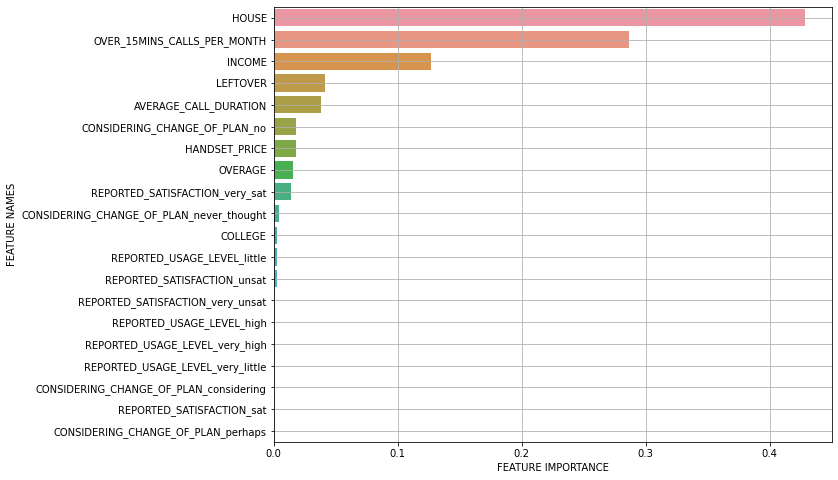

In [16]:
result = plot_feature_importance(model.feature_importances_, x_train.columns)

## 5.실습: random forest 튜닝

* grid search를 수행합니다.
    * ① n_estimators 의 갯수를 5 ~ 200까지 5개씩 증가시켜가며 튜닝해 봅시다.
    * ② max_features를 1 ~ feature갯수까지 1씩 증가시켜가며 튜닝해 봅시다.
    * ③ n_estimators, max_features를 동시에 튜닝.

* 모델링 후 cv 평가 결과를 차트로 그려봅시다. 
* 튜닝된 모델로 부터 변수중요도를 뽑아 봅시다.


### (1) n_estimators 튜닝

In [17]:
parmas = {'n_estimators':range(5,201,5)}

In [18]:
m = RandomForestClassifier()
m_gs1 = GridSearchCV(m, parmas, cv=5, verbose=3)

In [19]:
m_gs1.fit(x_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END .................................n_estimators=5; total time=   0.0s
[CV 2/5] END .................................n_estimators=5; total time=   0.0s
[CV 3/5] END .................................n_estimators=5; total time=   0.0s
[CV 4/5] END .................................n_estimators=5; total time=   0.0s
[CV 5/5] END .................................n_estimators=5; total time=   0.0s
[CV 1/5] END ................................n_estimators=10; total time=   0.0s
[CV 2/5] END ................................n_estimators=10; total time=   0.0s
[CV 3/5] END ................................n_estimators=10; total time=   0.0s
[CV 4/5] END ................................n_estimators=10; total time=   0.0s
[CV 5/5] END ................................n_estimators=10; total time=   0.0s
[CV 1/5] END ................................n_estimators=15; total time=   0.0s
[CV 2/5] END ................................n_

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': range(5, 201, 5)}, verbose=3)

In [20]:
m_gs1.best_score_, m_gs1.best_params_

(0.6911428571428572, {'n_estimators': 150})

In [21]:
p1 = m_gs1.predict(x_val)
print(classification_report(y_val,p1))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       769
           1       0.69      0.71      0.70       731

    accuracy                           0.71      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.71      0.71      0.71      1500



In [22]:
# 튜닝 결과를 데이터프레임으로 저장
result = pd.DataFrame(m_gs1.cv_results_)
temp = result.loc[:, ['param_n_estimators', 'mean_test_score']]
temp.head()

,param_n_estimators,mean_test_score
0,5,0.631143
1,10,0.656286
2,15,0.657714
3,20,0.668571
4,25,0.674286


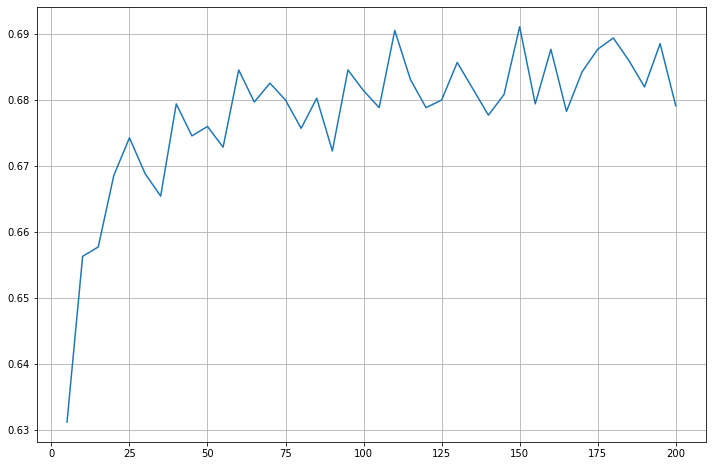

In [23]:
plt.figure(figsize = (12,8))
plt.plot('param_n_estimators', 'mean_test_score', data = temp)
plt.grid()
plt.show()

### (2) max_features 튜닝

② max_features를 1 ~ feature갯수까지 1씩 증가시켜가며 튜닝해 봅시다.

In [24]:
x_train.shape

(3500, 20)

In [25]:
f = len(data.columns)
params = {'max_features' : range(1,f)}

In [26]:
m2 = RandomForestClassifier()
m2_gs = GridSearchCV(m2, params, cv=5, verbose=3)
m2_gs.fit(x_train,y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END .................................max_features=1; total time=   0.2s
[CV 2/5] END .................................max_features=1; total time=   0.3s
[CV 3/5] END .................................max_features=1; total time=   0.3s
[CV 4/5] END .................................max_features=1; total time=   0.2s
[CV 5/5] END .................................max_features=1; total time=   0.3s
[CV 1/5] END .................................max_features=2; total time=   0.3s
[CV 2/5] END .................................max_features=2; total time=   0.3s
[CV 3/5] END .................................max_features=2; total time=   0.2s
[CV 4/5] END .................................max_features=2; total time=   0.3s
[CV 5/5] END .................................max_features=2; total time=   0.2s
[CV 1/5] END .................................max_features=3; total time=   0.3s
[CV 2/5] END .................................ma

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': range(1, 12)}, verbose=3)

In [27]:
print(m2_gs.best_score_, m2_gs.best_params_)
p2 = m2_gs.predict(x_val)
print(classification_report(y_val,p2))

0.692 {'max_features': 4}
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       769
           1       0.70      0.72      0.71       731

    accuracy                           0.72      1500
   macro avg       0.72      0.72      0.72      1500
weighted avg       0.72      0.72      0.72      1500



In [28]:
# 튜닝 결과를 데이터프레임으로 저장
result = pd.DataFrame(m2_gs.cv_results_)
temp = result.loc[:, ['param_n_estimators', 'mean_test_score']]
temp.head()

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['param_n_estimators'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [ ]:
plt.figure(figsize = (12,8))
plt.plot('param_n_estimators', 'mean_test_score', data = temp)
plt.grid()
plt.show()

-------------------------------------------------------------------------

In [29]:
x_train.shape

(3500, 20)

In [30]:
# 1~20
params = {'max_features': range(1,21)}

In [31]:
# 기본모델
m = RandomForestClassifier()

# 그리드서치 모델 선언
m_gs = GridSearchCV(m, params, cv=5, verbose= 3)

# m_gs = GridSearchCV(RandomForestClassifier(), params, cv=5)

In [32]:
# 튜닝
m_gs.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END .................................max_features=1; total time=   0.2s
[CV 2/5] END .................................max_features=1; total time=   0.2s
[CV 3/5] END .................................max_features=1; total time=   0.2s
[CV 4/5] END .................................max_features=1; total time=   0.2s
[CV 5/5] END .................................max_features=1; total time=   0.2s
[CV 1/5] END .................................max_features=2; total time=   0.2s
[CV 2/5] END .................................max_features=2; total time=   0.3s
[CV 3/5] END .................................max_features=2; total time=   0.3s
[CV 4/5] END .................................max_features=2; total time=   0.4s
[CV 5/5] END .................................max_features=2; total time=   0.3s
[CV 1/5] END .................................max_features=3; total time=   0.3s
[CV 2/5] END .................................m

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': range(1, 21)}, verbose=3)

In [ ]:
m_gs.best_params_

In [33]:
# 튜닝 결과를 데이터프레임으로 저장
result = pd.DataFrame(m_gs.cv_results_)
temp = result.loc[:, ['param_max_features', 'mean_test_score']]
temp.head()

,param_max_features,mean_test_score
0,1,0.656000
1,2,0.680571
2,3,0.678857
3,4,0.680857
4,5,0.684857


In [35]:
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.300495,0.005897,0.024841,0.003088,1,{'max_features': 1},0.638571,0.665714,0.674286,0.642857,0.658571,0.656000,0.013504,20
1,0.369847,0.047352,0.025078,0.001979,2,{'max_features': 2},0.658571,0.707143,0.677143,0.674286,0.685714,0.680571,0.015923,10
2,0.365823,0.006363,0.023211,0.002592,3,{'max_features': 3},0.657143,0.697143,0.671429,0.695714,0.672857,0.678857,0.015370,12
3,0.404163,0.006664,0.022875,0.001598,4,{'max_features': 4},0.661429,0.701429,0.670000,0.687143,0.684286,0.680857,0.013927,9
4,0.498267,0.034483,0.024621,0.004874,5,{'max_features': 5},0.660000,0.717143,0.688571,0.678571,0.680000,0.684857,0.018639,2
5,0.497683,0.007129,0.021262,0.001105,6,{'max_features': 6},0.657143,0.707143,0.698571,0.664286,0.680000,0.681429,0.019188,8
6,0.559176,0.037029,0.023214,0.003948,7,{'max_features': 7},0.658571,0.708571,0.685714,0.685714,0.675714,0.682857,0.016238,5
7,0.598307,0.038835,0.022541,0.001291,8,{'max_features': 8},0.658571,0.702857,0.680000,0.688571,0.685714,0.683143,0.014411,4
8,0.633436,0.008815,0.022747,0.003246,9,{'max_features': 9},0.664286,0.711429,0.687143,0.671429,0.691429,0.685143,0.016478,1
9,0.723199,0.049657,0.023245,0.001961,10,{'max_features': 10},0.664286,0.705714,0.675714,0.672857,0.691429,0.682000,0.014752,6


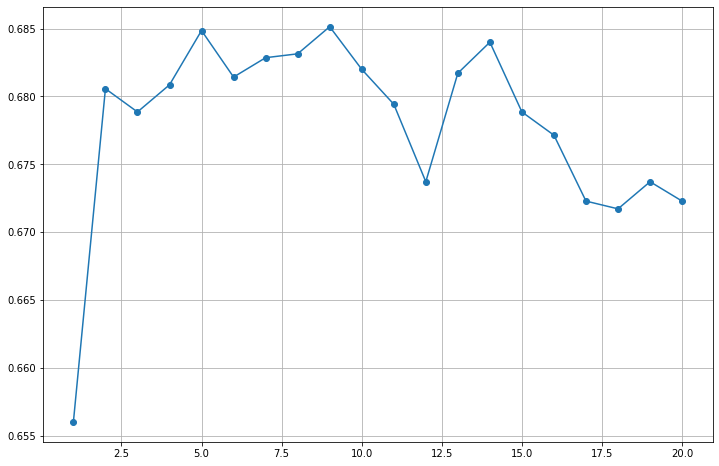

In [34]:
plt.figure(figsize = (12,8))
plt.plot('param_max_features', 'mean_test_score', data = temp, marker = 'o')
plt.grid()
plt.show()  # 경향을 살펴보는 것이 중요함!!!!!

* 변수 중요도

### (3) n_estimators와 max_features를 한꺼번에 튜닝

③ n_estimators, max_features를 동시에 튜닝.

In [ ]:
param = {'n_estimators':[20,50,100], 'max_features':range(1,21)}

In [ ]:
m3 = RandomForestClassifier()
m3_gs = GridSearchCV(m3, par, cv=5, verbose=3)
m3_gs.fit(x_train, y_train)
p3 = m3_gs.predict(x_val)

In [ ]:
print(m3_gs.best_score_,m3_gs.best_params_)
print(classification_report(y_val,p3))

In [ ]:
# 튜닝 결과를 데이터프레임으로 저장
result = pd.DataFrame(m3_gs.cv_results_)
temp = result.loc[:, ['param_n_estimators','param_max_features', 'mean_test_score']]
temp.head()

In [ ]:
plt.figure(figsize = (12,8))
sns.lineplot('param_max_features', 'mean_test_score', data = temp
             , hue = 'param_n_estimators')
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize = (12,8))
plt.plot('param_max', 'mean_test_score', data = temp, marker = 'o')
plt.grid()
plt.show()  # 경향을 살펴보는 것이 중요함!!!!!